In [1]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES']='2'
%matplotlib inline

/home/lhw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/lhw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#数据读取
train_file_path = './data/training.csv'
test_file_path = './data/test.csv'

train_pd = pd.read_csv(train_file_path)
test_pd = pd.read_csv(test_file_path)
#去除含空值的行
train_pd.dropna(axis=0, how='any', inplace=True)
print(train_pd.shape)

(2140, 31)


In [3]:
from joblib import Parallel, delayed
def format_img(x):
    return np.asarray([int(e) for e in x.split(' ')], dtype=np.uint8).reshape(96, 96)
#并行处理，将图片抽取出来
with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    train_img = ex(delayed(format_img)(e) for e in train_pd.Image)
with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    test_img = ex(delayed(format_img)(e) for e in test_pd.Image)
train_img = np.stack(train_img)[..., None]
test_img = np.stack(test_img)[..., None]
print(train_img.shape, test_img.shape)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done 2140 out of 2140 | elapsed:   14.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    8.2s


(2140, 96, 96, 1) (1783, 96, 96, 1)


[Parallel(n_jobs=10)]: Done 1783 out of 1783 | elapsed:   11.9s finished


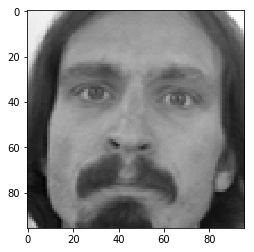

In [4]:
plt.imshow(train_img[0, :, :, 0], cmap='gray')
plt.show()

In [5]:
#获取关键点坐标
train_y = train_pd.iloc[:, :-1].values
print(train_y.shape)
print(train_y[1, :])

(2140, 30)
[64.33293617 34.9700766  29.9492766  33.44871489 58.85617021 35.27434894
 70.7227234  36.18716596 36.0347234  34.36153191 24.47251064 33.14444255
 53.98740426 28.27594894 78.63421277 30.4059234  42.72885106 26.14604255
 16.8653617  27.05885957 48.20629787 55.66093617 56.42144681 76.352
 35.12238298 76.04765957 46.68459574 70.26655319 45.46791489 85.48017021]


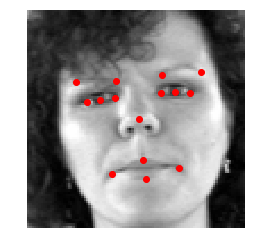

In [6]:
#将关键点和图像相融合
def show(x, y=None):
    plt.imshow(x[..., 0], 'gray')
    if y is not None:
        #np.vstack(np.split(y, 15))先切分成15组，再按组相连 
        #[1, 2, 3, 4,, 5, 6]=>[1, 2,],[3, 4], [5, 6]=>[[1,2], [3, 4], [5, 6]]
        points = np.vstack(np.split(y, 15)).T
        plt.plot(points[0], points[1], 'o', color = 'red')
    plt.axis('off')
sample_idx = np.random.choice(len(train_img))
show(train_img[sample_idx], train_y[sample_idx])

In [7]:
#数据预处理
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_img, train_y, test_size=0.2, random_state=42, shuffle=True)#random_state：是随机数的种子
print(x_train.shape, x_val.shape)
print(y_val[0].shape)

(1712, 96, 96, 1) (428, 96, 96, 1)
(30,)


In [39]:
#定义模型
def model(input, is_training):
    with tf.variable_scope('layer1'):
        conv1 = tf.layers.conv2d(input, 32, 5, strides=1, padding='VALID')
        relu1 = tf.nn.relu(conv1)
        norm1 = tf.layers.batch_normalization(relu1, center=True, scale=True, training=True)
        pool1 = tf.layers.max_pooling2d(norm1, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer2'):
        conv2 = tf.layers.conv2d(pool1, 64, 5, strides=1, padding='VALID')
        relu2= tf.nn.relu(conv2)
        norm2 = tf.layers.batch_normalization(relu2, center=True, scale=True, training=True)
        pool2 = tf.layers.max_pooling2d(norm2, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer3'):
        conv3 = tf.layers.conv2d(pool2, 128, 2, strides=1, padding='VALID')
        relu3 = tf.nn.relu(conv3)
        norm3 = tf.layers.batch_normalization(relu3, center=True, scale=True, training=True)
        pool3 = tf.layers.max_pooling2d(norm3, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer4'):
        flatten = tf.reshape(pool3, [-1, 10*10*128])
        layer4 = tf.layers.dense(flatten, 512)#1024
        relu4 = tf.nn.relu(layer4)
        if is_training == True:
            relu4 = tf.layers.dropout(relu4, 0.5)
    '''
    with tf.variable_scope('layer5'):
        layer5 = tf.layers.dense(relu4, 512)
        relu5 = tf.nn.relu(layer5)
        if is_training == True:
            relu5 = tf.layers.dropout(relu5, 0.5)   
    '''

    with tf.variable_scope('layer6'):
        #layer6 = tf.layers.dense(relu5, 512)
        output = tf.layers.dense(relu4, 30)#relu5
        #output = tf.tanh(relu5)
    return output
#改网络https://github.com/saber1988/facial-keypoints-detection/blob/master/facial_keypoints_detection.py

In [40]:
#训练
#训练参数
BATCH_SIZE = 128
EPOCHS = 1000             #迭代次数
EARLY_STOP_PATIENCE = 100 #控制early stopping的参数

#训练数据归一化
x_train_norm = x_train / 255.0
y_train_norm = (y_train - 48.0) / 48.0
x_val_norm = x_val / 255.0
y_val_norm = (y_val - 48.0) / 48.0

ckpt_path = './model/model.ckpt'
tf.reset_default_graph()
x_data = tf.placeholder(tf.float32, [None, 96, 96, 1])
y_data = tf.placeholder(tf.float32, [None, 30])
is_training = tf.placeholder(tf.bool)

out = model(x_data, is_training)
#损失函数 rsme
rmse = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(y_data - out), 1)))
# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(
    1e-3,                      # Base learning rate.
    global_step * BATCH_SIZE,  # Current index into the dataset.
    len(x_train),                # Decay step.
    0.95,                      # Decay rate.
    staircase=True)

train_step = tf.train.AdamOptimizer(learning_rate, 0.95).minimize(rmse, global_step=global_step)
#train_step = tf.train.AdamOptimizer(1e-3).minimize(rmse)
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    best_validation_loss = 1000000.0
    current_epoch = 0
    
    epoch = EPOCHS
    batch_size = BATCH_SIZE
    num_batch = len(x_train) // batch_size
    remainder = len(x_train) % batch_size
    print("数据分 %s 批， 前面每批数据 %s 个数据， 最后一批 %s 个数据" % (num_batch, batch_size, remainder))
    
    for n in range(epoch):
        #添加交叉验证
        #x_train, x_val, y_train, y_val = train_test_split(train_img, train_y, test_size=0.2, random_state=42, shuffle=True)
        for i in range(num_batch):
            x_batch = x_train_norm[i*batch_size : (i+1)*batch_size]
            y_batch = y_train_norm[i*batch_size : (i+1)*batch_size]
            _, loss_step = sess.run([train_step, rmse], \
                             feed_dict={x_data:x_batch, y_data:y_batch, is_training:True})
        if remainder > 0:
            start_index = num_batch * batch_size
            x_batch = x_train_norm[start_index : len(x_train)-1]
            y_batch = y_train_norm[start_index : len(x_train)-1]
            _, loss_step = sess.run([train_step, rmse], \
                             feed_dict={x_data:x_batch, y_data:y_batch, is_training:True})
        if n % 5 == 0:
            validation_loss = rmse.eval(feed_dict={x_data:x_val_norm, y_data:y_val_norm, is_training:False})
            print("epoch %d train loss is %f validataion loss is %f" % (n, loss_step, validation_loss))
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            current_epoch = n
        elif (n - current_epoch) >= EARLY_STOP_PATIENCE:
            print('early stoping')
            break
    saver.save(sess, ckpt_path)

数据分 13 批， 前面每批数据 128 个数据， 最后一批 48 个数据
epoch 0 train loss is 2.209889 validataion loss is 2.218125
epoch 5 train loss is 0.578365 validataion loss is 0.611952
epoch 10 train loss is 0.403745 validataion loss is 0.459257
epoch 15 train loss is 0.313049 validataion loss is 0.366242
epoch 20 train loss is 0.289956 validataion loss is 0.338303
epoch 25 train loss is 0.277461 validataion loss is 0.325599
epoch 30 train loss is 0.270848 validataion loss is 0.319102
epoch 35 train loss is 0.268475 validataion loss is 0.311490
epoch 40 train loss is 0.263700 validataion loss is 0.311433
epoch 45 train loss is 0.263655 validataion loss is 0.315708
epoch 50 train loss is 0.269347 validataion loss is 0.308184
epoch 55 train loss is 0.256986 validataion loss is 0.305304
epoch 60 train loss is 0.255680 validataion loss is 0.304335
epoch 65 train loss is 0.254569 validataion loss is 0.303570
epoch 70 train loss is 0.253667 validataion loss is 0.302943
epoch 75 train loss is 0.252951 validataion loss 

In [22]:
def show_pred(x, y_real, y_pred):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for ax in axes:
        ax.imshow(x[0, ..., 0], 'gray')
        ax.axis('off')
    points_real = np.vstack(np.split(y_real[0], 15)).T 
    points_pred = np.vstack(np.split(y_pred[0], 15)).T 
    axes[0].plot(points_pred[0], points_pred[1], 'o', color='red')
    axes[0].set_title('Predictions', size=16)
    axes[1].plot(points_real[0], points_real[1], 'o', color='green')
    axes[1].plot(points_pred[0], points_pred[1], 'o', color='red', alpha=0.5)
    axes[1].set_title('Real', size=16)

INFO:tensorflow:Restoring parameters from ./model/model.ckpt


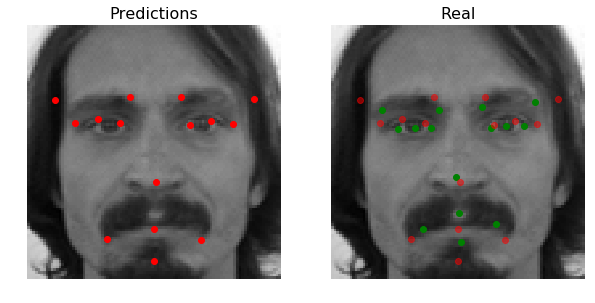

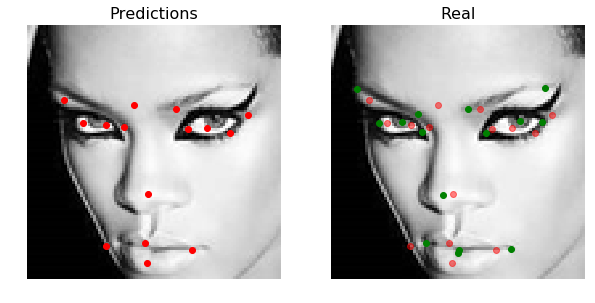

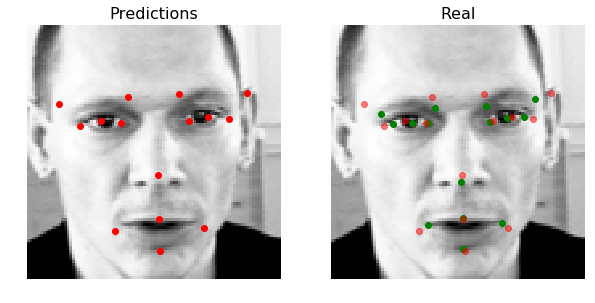

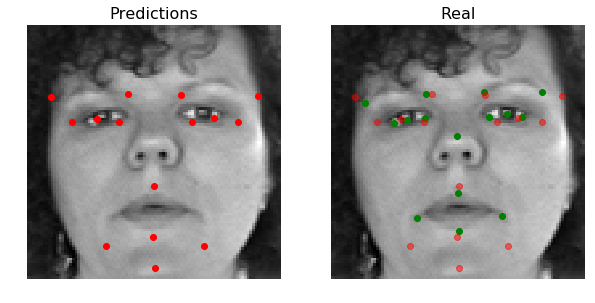

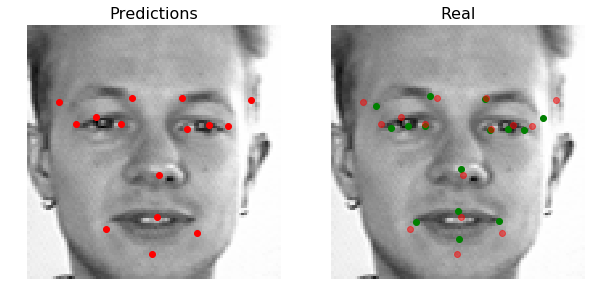

In [41]:
#测试
ckpt_path = './model/model.ckpt'
tf.reset_default_graph()
x_val_data = tf.placeholder(tf.float32, [None, 96, 96, 1])
is_training = tf.placeholder(tf.bool)
predict = model(x_val_data, is_training)
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, ckpt_path)
    for i in range(5):
        idx = np.random.choice(len(x_val))
        sample_x = x_val[idx, None]#增加一维(1, 96, 96, 1) 而x_val[0]=>( 96, 96, 1)
        sample_y = y_val[idx, None]
        #sess.run(predict, feed_dict={x_val_data:sample_x, is_training:False})
        pred = predict.eval(feed_dict={x_val_data:sample_x, is_training:False})
        show_pred(sample_x, sample_y, pred * 48.0 + 48.0)

INFO:tensorflow:Restoring parameters from ./model/model.ckpt


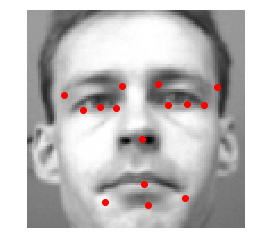

In [71]:
#测试
ckpt_path = './model/model.ckpt'
tf.reset_default_graph()
x_val_data = tf.placeholder(tf.float32, [None, 96, 96, 1])
is_training = tf.placeholder(tf.bool)
predict = model(x_val_data, is_training)
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, ckpt_path)
    sample_x = test_img[3, None]
    pred = predict.eval(feed_dict={x_val_data:sample_x, is_training:False})
    show(test_img[3], pred[0])

In [10]:
#提交结果
keypoint_index = {
    'left_eye_center_x':0,
    'left_eye_center_y':1,
    'right_eye_center_x':2,
    'right_eye_center_y':3,
    'left_eye_inner_corner_x':4,
    'left_eye_inner_corner_y':5,
    'left_eye_outer_corner_x':6,
    'left_eye_outer_corner_y':7,
    'right_eye_inner_corner_x':8,
    'right_eye_inner_corner_y':9,
    'right_eye_outer_corner_x':10,
    'right_eye_outer_corner_y':11,
    'left_eyebrow_inner_end_x':12,
    'left_eyebrow_inner_end_y':13,
    'left_eyebrow_outer_end_x':14,
    'left_eyebrow_outer_end_y':15,
    'right_eyebrow_inner_end_x':16,
    'right_eyebrow_inner_end_y':17,
    'right_eyebrow_outer_end_x':18,
    'right_eyebrow_outer_end_y':19,
    'nose_tip_x':20,
    'nose_tip_y':21,
    'mouth_left_corner_x':22,
    'mouth_left_corner_y':23,
    'mouth_right_corner_x':24,
    'mouth_right_corner_y':25,
    'mouth_center_top_lip_x':26,
    'mouth_center_top_lip_y':27,
    'mouth_center_bottom_lip_x':28,
    'mouth_center_bottom_lip_y':29
}    

In [44]:
#测试
ckpt_path = './model/model.ckpt'
tf.reset_default_graph()
x_test_data = tf.placeholder(tf.float32, [None, 96, 96, 1])
is_training = tf.placeholder(tf.bool)
predict = model(x_test_data, is_training)
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, ckpt_path)
    y_pred = []
    test_size = test_img.shape[0]
    batch_size = 1
    num_batch = test_size // batch_size
    remainder = test_size % batch_size
    print("数据分 %s 批， 前面每批数据 %s 个数据， 最后一批 %s 个数据" % (num_batch, batch_size, remainder))
    for i in range(num_batch):
        x_batch = test_img[i*batch_size : (i+1)*batch_size]
        #sess.run(predict, feed_dict={x_test_data:x_batch, is_training:False})
        y_pred_batch = predict.eval(feed_dict={x_test_data:x_batch, is_training:False})
        y_pred.append(y_pred_batch)
    if remainder > 0:
        start_idx = num_batch * batch_size
        x_batch = test_img[start_idx : test_size-1]
        y_pred_batch = predict.eval(feed_dict={x_test_data:x_batch, is_training:False})
        y_pred.append(y_pred_batch)
    print("predict test image done!")
    y_pred_np = np.array(y_pred)
    y = y_pred_np.reshape(-1, 30)
    #print(y.shape)
    output_file = open("submit.csv", 'w')
    output_file.write('RowId,location\n')
    id_lookup_table = open('data/IdLookupTable.csv')
    id_lookup_table.readline()
    for line in id_lookup_table:
        RowId,ImageId,FeatureName = line.rstrip().split(',')
        image_index = int(ImageId) - 1
        feature_index = keypoint_index[FeatureName]
        feature_location = y[image_index][feature_index]
        output_file.write('{0},{1}\n'.format(RowId,feature_location))
    output_file.close()
    id_lookup_table.close()
    print('Finish!')

INFO:tensorflow:Restoring parameters from ./model/model.ckpt
数据分 1783 批， 前面每批数据 1 个数据， 最后一批 0 个数据
predict test image done!
Finish!


In [13]:
#用nn模块实现，可以做到权重正则化
def get_weight(shape, reg=0.001):
    var = tf.Variable(tf.random_normal(shape), dtype=tf.float32)
    tf.add_to_collection("losses", tf.contrib.layers.l2_regularizer(reg)(var))
    return var
def model_nn(input, is_training):
    with tf.variable_scope('layer1'):
        conv1_weight = get_weight([5, 5, 1, 32])
        conv1_biases = tf.Variable(tf.constant(0.1, shape=[32]))
        conv1 = tf.nn.conv2d(input, conv1_weight, strides=[1, 1, 1, 1], padding='VALID')
        relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))
        pool1 = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    with tf.variable_scope('layer2'):
        conv2_weight = get_weight([5, 5, 32, 64])
        conv2_biases = tf.Variable(tf.constant(0.1, shape=[64]))
        conv2 = tf.nn.conv2d(pool1, conv2_weight, strides=[1, 1, 1, 1], padding='VALID')
        relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))
        pool2 = tf.nn.max_pool(relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    with tf.variable_scope('layer3'):
        conv3_weight = get_weight([2, 2, 64, 128])
        conv3_biases = tf.Variable(tf.constant(0.1, shape=[128]))
        conv3 = tf.nn.conv2d(pool2, conv3_weight, strides=[1, 1, 1, 1], padding='VALID')
        relu3 = tf.nn.relu(tf.nn.bias_add(conv3, conv3_biases))
        pool3 = tf.nn.max_pool(relu3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    with tf.variable_scope('layer4'):
        flatten = tf.reshape(pool3, [-1, 10*10*128])
        fc1_weight = get_weight([10*10*128, 1024])
        fc1_biases = tf.Variable(tf.constant(0.1, shape=[1024]))
        fc1 = tf.nn.relu(tf.matmul(flatten, fc1_weight) + fc1_biases)
        if is_training == True:
            fc1 = tf.nn.dropout(fc1, 0.5)
    with tf.variable_scope('layer5'):
        fc2_weight = get_weight([1024, 512])
        fc2_biases = tf.Variable(tf.constant(0.1, shape=[512]))
        fc2 = tf.nn.relu(tf.matmul(fc1, fc2_weight) + fc2_biases)
        if is_training == True:
            fc2 = tf.nn.dropout(fc2, 0.5)
    with tf.variable_scope('layer6'):
        fc3_weight = get_weight([512, 30])
        fc3_biases = tf.Variable(tf.constant(0.1, shape=[30]))
        output = tf.matmul(fc2, fc3_weight) + fc3_biases
    return output

In [14]:
#训练
#训练参数
BATCH_SIZE = 128
EPOCHS = 1000             #迭代次数
EARLY_STOP_PATIENCE = 100 #控制early stopping的参数

ckpt_path = './model/model.ckpt'
tf.reset_default_graph()
x_data = tf.placeholder(tf.float32, [None, 96, 96, 1])
y_data = tf.placeholder(tf.float32, [None, 30])
is_training = tf.placeholder(tf.bool)

out = model_nn(x_data, is_training)
#损失函数 rsme
rmse = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(y_data - out), 1)))
tf.add_to_collection("losses", rmse)
loss = tf.add_n(tf.get_collection("losses"))#和正则项联合
# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(
    1e-3,                      # Base learning rate.
    global_step * BATCH_SIZE,  # Current index into the dataset.
    len(x_train),                # Decay step.
    0.95,                      # Decay rate.
    staircase=True)

train_step = tf.train.AdamOptimizer(learning_rate, 0.95).minimize(loss, global_step=global_step)
#train_step = tf.train.AdamOptimizer(1e-3).minimize(rmse)
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    best_validation_loss = 1000000.0
    current_epoch = 0
    
    epoch = EPOCHS
    batch_size = BATCH_SIZE
    num_batch = len(x_train) // batch_size
    remainder = len(x_train) % batch_size
    print("数据分 %s 批， 前面每批数据 %s 个数据， 最后一批 %s 个数据" % (num_batch, batch_size, remainder))
    
    for n in range(epoch):
        for i in range(num_batch):
            x_batch = x_train[i*batch_size : (i+1)*batch_size]
            y_batch = y_train[i*batch_size : (i+1)*batch_size]
            _, loss_step = sess.run([train_step, rmse], \
                             feed_dict={x_data:x_batch, y_data:y_batch, is_training:True})
        if remainder > 0:
            start_index = num_batch * batch_size
            x_batch = x_train[start_index : len(x_train)-1]
            y_batch = y_train[start_index : len(x_train)-1]
            _, loss_step = sess.run([train_step, rmse], \
                             feed_dict={x_data:x_batch, y_data:y_batch, is_training:True})
        if n % 5 == 0:
            validation_loss = rmse.eval(feed_dict={x_data:x_val, y_data:y_val, is_training:False})
            print("epoch %d train loss is %f validataion loss is %f" % (n, loss_step, validation_loss))
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            current_epoch = n
        elif (n - current_epoch) >= EARLY_STOP_PATIENCE:
            print('early stoping')
            break
    saver.save(sess, ckpt_path)

数据分 13 批， 前面每批数据 128 个数据， 最后一批 48 个数据
epoch 0 train loss is 6360571392.000000 validataion loss is 5721182720.000000
epoch 5 train loss is 1895366656.000000 validataion loss is 2002853888.000000
epoch 10 train loss is 1296053632.000000 validataion loss is 1460504832.000000
epoch 15 train loss is 1032659200.000000 validataion loss is 1234679808.000000
epoch 20 train loss is 890419520.000000 validataion loss is 1095004672.000000
epoch 25 train loss is 805769984.000000 validataion loss is 1006469056.000000
epoch 30 train loss is 749557312.000000 validataion loss is 944393536.000000
epoch 35 train loss is 709863872.000000 validataion loss is 901227072.000000
epoch 40 train loss is 680926976.000000 validataion loss is 869939072.000000
epoch 45 train loss is 660212928.000000 validataion loss is 847153024.000000
epoch 50 train loss is 644944320.000000 validataion loss is 830187008.000000
epoch 55 train loss is 632850816.000000 validataion loss is 816748864.000000
epoch 60 train loss is 6234999